<div style="background-color:#1e1e1e; color:#d4d4d4; padding:25px; border-radius:10px; font-family:Segoe UI, sans-serif; line-height:1.6;">

<h1 style="color:#61dafb; text-align:center;">📡 Real-Time Sentiment Analysis with Online Learning</h1>

<h2 style="color:#56b6c2;">1️⃣ Motivation</h2>
<p>
In the age of social media, data arrives continuously — tweets, comments, and posts are generated every second. 
Traditional <b>batch learning</b> models require retraining from scratch when new data arrives, which:
</p>
<ul>
<li>Consumes significant resources (CPU, memory, time).</li>
<li>Cannot adapt fast enough to sudden changes in trends or topics.</li>
<li>Is impractical for endless data streams.</li>
</ul>
<p>
<b>Online Learning</b> (or Incremental Learning) solves this by updating the model immediately as new data arrives, without reprocessing all past data. 
This makes it ideal for <span style="color:#98c379;">real-time sentiment analysis</span>, fraud detection, and dynamic recommendation systems.
</p>

<h2 style="color:#56b6c2;">2️⃣ Project Goal</h2>
<p>
We will build an <b>online sentiment analysis system</b> that processes tweets in small batches, 
predicts their sentiment (<span style="color:#98c379;">Positive</span> / <span style="color:#e06c75;">Negative</span>), 
and continuously improves as new data arrives.
</p>

<h2 style="color:#56b6c2;">3️⃣ Dataset — Sentiment140</h2>
<ul>
<li><b>Source:</b> <a href="https://www.kaggle.com/datasets/kazanova/sentiment140" style="color:#61dafb;">Sentiment140 Dataset</a></li>
<li><b>Size:</b> 1.6 million labeled tweets</li>
<li><b>Labels:</b> 0 = Negative, 4 = Positive (will convert 4 → 1 for binary classification)</li>
<li><b>Content:</b> Raw tweet text, no emojis, collected via Twitter API</li>
</ul>

<h2 style="color:#56b6c2;">4️⃣ Approach</h2>
<ol>
<li><b>Load and preprocess</b> the Sentiment140 dataset.</li>
<li>Use <code>HashingVectorizer</code> for text-to-vector transformation (efficient in streaming scenarios).</li>
<li>Train an <b>SGDClassifier</b> model incrementally using <code>partial_fit</code>.</li>
<li>Simulate a stream of tweets in <b>mini-batches</b> (batch size: 10,000 rows).</li>
<li>Record and plot <b>accuracy over time</b> to see model improvement.</li>
</ol>

<h2 style="color:#56b6c2;">5️⃣ Why Online Learning for This Task?</h2>
<ul>
<li>Handles <b>continuous inflow</b> of social media data.</li>
<li>Works within <b>limited memory</b> — no need to store all past tweets.</li>
<li><b>Fast adaptation</b> to changing topics, slang, and trends.</li>
</ul>

<h2 style="color:#56b6c2;">6️⃣ Expected Outcome</h2>
<p>
By the end of this notebook, we’ll have a working real-time sentiment classifier that can learn from new tweets without full retraining. 
This approach can be extended to live Twitter APIs and other streaming data sources.
</p>

<hr style="border: 1px solid #333; margin: 20px 0;">
<p style="text-align:center; color:#888;">
<strong>Author's Note:</strong> This notebook uses a simulated streaming setup on the Sentiment140 dataset. The same code can be adapted to handle live Twitter data.
</p>

</div>


<div style="background-color:#1e1e1e; color:#d4d4d4; padding:20px; border-radius:8px; font-family:Segoe UI;">
<h2 style="color:#56b6c2;">Step 1 — Import Libraries & Load Dataset</h2>
<p>We start by importing the core Python libraries for online learning and sentiment analysis:</p>
<ul>
<li><b>pandas</b> — to handle tabular data</li>
<li><b>numpy</b> — for numeric operations</li>
<li><b>sklearn</b> — for vectorization and the online learning model</li>
<li><b>matplotlib</b> — for accuracy visualization</li>
</ul>
<p>We then load a labeled Twitter dataset, where each sample contains the text of the tweet and a label:
<span style="color:#98c379;">1 for positive</span> and <span style="color:#e06c75;">0 for negative</span>.</p>
</div>


In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer


<div style="background-color:#1e1e1e; color:#d4d4d4; padding:25px; border-radius:10px; font-family:Segoe UI, sans-serif; line-height:1.6;">

<h2 style="color:#56b6c2;">Step 2 — Load & Preprocess the Dataset</h2>

<p>
In this step, we load the <b>Sentiment140 dataset</b> and prepare it for streaming-based online learning. 
Since the dataset includes extra columns we don’t need, we will:
</p>

<ol>
<li>Read the CSV with <code>pandas</code> using the correct encoding (<code>latin-1</code>) to handle special characters.</li>
<li>Keep only the <b>label</b> and <b>tweet text</b> columns.</li>
<li>Convert labels:
    <span style="color:#e06c75;">0</span> → Negative,
    <span style="color:#98c379;">4</span> → Positive → mapped to <span style="color:#98c379;">1</span> for binary classification.</li>
<li>Shuffle the dataset to simulate random arrival of tweets in a data stream.</li>
<li>Split into training and test datasets, where the test set remains fixed for evaluation across streaming batches.</li>
</ol>

<p>
This preprocessing ensures our model sees tweets in a mixed, unpredictable order — closer to a real online environment.
</p>

</div>


In [2]:
# Load Sentiment140 dataset
# Kaggle path: /kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv
# Columns: target, ids, date, flag, user, text

df = pd.read_csv(
    "/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv",
    encoding="latin-1",
    header=None
)

# Keep only sentiment and text
df = df[[0, 5]]
df.columns = ['label', 'text']

# Map labels: 0 -> 0 (negative), 4 -> 1 (positive)
df['label'] = df['label'].replace({4: 1})

# Shuffle dataset to simulate random streaming
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Train-test split (e.g., 90% train for streaming simulation, 10% fixed test set)
train_size = int(len(df) * 0.9)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# Show dataset info
print(train_df.head())
print(train_df['label'].value_counts())


   label                                               text
0      0             @chrishasboobs AHHH I HOPE YOUR OK!!! 
1      0  @misstoriblack cool , i have no tweet apps  fo...
2      0  @TiannaChaos i know  just family drama. its la...
3      0  School email won't open  and I have geography ...
4      0                             upper airways problem 
label
1    720035
0    719965
Name: count, dtype: int64


<div style="background-color:#1e1e1e; color:#d4d4d4; padding:25px; border-radius:10px; font-family:Segoe UI, sans-serif; line-height:1.6;">

<h2 style="color:#56b6c2;">Step 2 Output — Preprocessed Dataset Overview</h2>

<p>
After loading and preprocessing the Sentiment140 dataset, we now have a clean,  
stream-ready dataframe containing only two columns:
</p>

<ul>
<li><span style="color:#61dafb;">label</span> — Sentiment label (0 = Negative, 1 = Positive).</li>
<li><span style="color:#61dafb;">text</span> — The raw tweet content.</li>
</ul>



<h3 style="color:#98c379;">Class Distribution</h3>
<pre style="background-color:#2d2d2d; padding:10px; border-radius:5px;">
1 (Positive)    720,035
0 (Negative)    719,965
</pre>

<p>
💡 The dataset is nicely balanced, with nearly equal numbers of positive and negative tweets.  
This helps ensure fair training and evaluation in our streaming simulation.
</p>

</div>


<div style="background-color:#1e1e1e; color:#d4d4d4; padding:25px; border-radius:10px; font-family:Segoe UI, sans-serif; line-height:1.6;">

<h2 style="color:#56b6c2;">Step 3 — Convert Tweets to Numerical Features (Vectorization)</h2>

<p>
Machine learning models cannot work directly with raw text. We need a way to represent each tweet as a  
<b>vector of numbers</b> that captures its words and patterns while being efficient to update incrementally.
</p>

<p>
For streaming sentiment analysis, we will use:
</p>
<ul>
<li><b>HashingVectorizer</b> from scikit-learn — transforms text into a fixed-length numeric vector  
using a hash function instead of storing a growing vocabulary.</li>
<li>No need to <b>fit</b> the vectorizer in advance — it works directly on batches, fitting perfectly in  
our <span style="color:#98c379;">online learning pipeline</span>.</li>
<li>Dimensionality is fixed (we’ll use 2<sup>18</sup> features) — balances accuracy and memory usage.</li>
</ul>

<p>
<b>Advantages in our streaming setup:</b>
</p>
<ol>
<li>Memory-efficient: doesn't store token-to-index mappings.</li>
<li>Fast: can handle large datasets like Sentiment140 with millions of examples.</li>
<li>Stateless: works with individual batches without keeping previous text in memory.</li>
</ol>

</div>


In [3]:

# Initialize HashingVectorizer
vectorizer = HashingVectorizer(
    n_features=2**18,
    alternate_sign=False,  # ensures non-negative values
    lowercase=True,
    stop_words='english'
)

# Transform a small sample of training tweets to confirm it works
X_sample = vectorizer.transform(train_df['text'][:5])
y_sample = train_df['label'][:5]

print(X_sample.shape)
print(y_sample.values)


(5, 262144)
[0 0 0 0 0]


<div style="background-color:#1e1e1e; color:#d4d4d4; padding:25px; border-radius:10px; font-family:Segoe UI, sans-serif; line-height:1.6;">

<h2 style="color:#56b6c2;">Step 3 Output — Vectorized Tweets</h2>

<p>
Our <b>HashingVectorizer</b> has transformed the text of tweets into a fixed-length numeric representation,  
making them ready for incremental learning with <code>SGDClassifier</code>.
</p>

<h3 style="color:#98c379;">Sample Transformation</h3>
<pre style="background-color:#2d2d2d; padding:10px; border-radius:5px;">
Shape: (5, 262144)
Labels: [0, 0, 0, 0, 0]
</pre>

<p>
📊 This means:
</p>
<ul>
<li>We processed <b>5 tweets</b> in this sample.</li>
<li>Each tweet was converted into a vector with <b>262,144 features</b>.</li>
<li>Labels confirm that all 5 example tweets were <span style="color:#e06c75;">negative (0)</span> in sentiment.</li>
</ul>

<p>
The full training set will be streamed in similar numeric batches directly into our online learner.
</p>

</div>


<div style="background-color:#1e1e1e; color:#d4d4d4; padding:25px; border-radius:10px; font-family:Segoe UI, sans-serif; line-height:1.6;">

<h2 style="color:#56b6c2;">Step 4 — Build the Online Model & Streaming Training Loop</h2>

<p>
Now that our tweets are represented as fixed-length numeric vectors, we can train an <b>online learning model</b>.
We’ll use:
</p>

<ul>
<li><b>SGDClassifier</b> (Stochastic Gradient Descent) — supports <code>partial_fit</code>, allowing incremental updates.</li>
<li>Loss function: <code>log_loss</code> (logistic regression) for binary classification.</li>
<li>Validation: after each batch, we’ll test on the fixed test set to monitor accuracy.</li>
</ul>

<h3 style="color:#98c379;">Streaming Simulation</h3>
<ol>
<li>Break the training dataset into small batches (e.g., 10,000 tweets each).</li>
<li>For each batch:
    <ul>
        <li>Vectorize the text using our <code>HashingVectorizer</code>.</li>
        <li>Update the model with <code>partial_fit</code>.</li>
        <li>Predict on the fixed test set and record accuracy.</li>
    </ul>
</li>
<li>This simulates real-time data arrival without needing a live Twitter API.</li>
</ol>

<p>
💡 Incremental updates mean we don’t start training from scratch for each batch — the model’s knowledge grows over time.
</p>

</div>


<div style="background-color:#1e1e1e; color:#d4d4d4; padding:25px; border-radius:10px; font-family:Segoe UI, sans-serif; line-height:1.6;">

<h2 style="color:#56b6c2;">Understanding SGDClassifier & Log Loss</h2>

<h3 style="color:#61dafb;">SGDClassifier</h3>
<p>
The <b>SGDClassifier</b> is a machine learning model that trains using 
<b>Stochastic Gradient Descent (SGD)</b>. Instead of processing the entire dataset 
at once, it updates its parameters one batch (or one sample) at a time — ideal for 
<b>online learning</b>.
</p>

<ul>
<li><b>Key Points:</b>
    <ul>
        <li>Efficient for large datasets and streaming data.</li>
        <li>Works with different loss functions (e.g., log loss, hinge loss).</li>
        <li>Incrementally learns via <code>partial_fit</code>.</li>
    </ul>
</li>
</ul>

<pre style="background-color:#2d2d2d; padding:10px; border-radius:5px;">
Update rule: 
w ← w - η ∇L(w; xᵢ, yᵢ)

Where:
w   = model weights
η   = learning rate
L   = loss function
xᵢ, yᵢ = sample features and label
</pre>

<hr style="border:1px solid #333; margin:20px 0;">

<h3 style="color:#61dafb;">Log Loss (Logistic Loss)</h3>
<p>
<b>Log Loss</b> measures the performance of a classifier whose output is a probability 
between 0 and 1. It penalizes confident but wrong predictions much more than 
less confident mistakes.
</p>

<ul>
<li><b>Formula:</b></li>
</ul>

<pre style="background-color:#2d2d2d; padding:10px; border-radius:5px;">
LogLoss = - (1/N) Σ [ yᵢ log(pᵢ) + (1 - yᵢ) log(1 - pᵢ) ]

Where:
N   = number of samples
yᵢ  = true label (0 or 1)
pᵢ  = predicted probability of the positive class
</pre>

<p>
✅ Lower log loss means better calibrated probability predictions, not just more accurate labels.
</p>

</div>


In [4]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Prepare fixed test set
X_test = vectorizer.transform(test_df['text'])
y_test = test_df['label'].values

# Initialize online learner
model = SGDClassifier(loss='log_loss', max_iter=1)

# Classes need to be defined for partial_fit in the first call
classes = np.array([0, 1])

# Training parameters
batch_size = 10000
num_batches = int(len(train_df) / batch_size)

accuracy_over_time = []

# Streaming training loop
for i in range(num_batches):
    batch_df = train_df.iloc[i*batch_size:(i+1)*batch_size]
    X_batch = vectorizer.transform(batch_df['text'])
    y_batch = batch_df['label'].values
    
    # Online model update
    if i == 0:
        model.partial_fit(X_batch, y_batch, classes=classes)
    else:
        model.partial_fit(X_batch, y_batch)
    
    # Evaluate on test set
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracy_over_time.append(acc)
    
    print(f"Batch {i+1}/{num_batches} - Accuracy: {acc:.4f}")


Batch 1/144 - Accuracy: 0.7127
Batch 2/144 - Accuracy: 0.7308
Batch 3/144 - Accuracy: 0.7352
Batch 4/144 - Accuracy: 0.7374
Batch 5/144 - Accuracy: 0.7388
Batch 6/144 - Accuracy: 0.7401
Batch 7/144 - Accuracy: 0.7416
Batch 8/144 - Accuracy: 0.7430
Batch 9/144 - Accuracy: 0.7450
Batch 10/144 - Accuracy: 0.7442
Batch 11/144 - Accuracy: 0.7419
Batch 12/144 - Accuracy: 0.7437
Batch 13/144 - Accuracy: 0.7430
Batch 14/144 - Accuracy: 0.7448
Batch 15/144 - Accuracy: 0.7445
Batch 16/144 - Accuracy: 0.7444
Batch 17/144 - Accuracy: 0.7456
Batch 18/144 - Accuracy: 0.7459
Batch 19/144 - Accuracy: 0.7458
Batch 20/144 - Accuracy: 0.7444
Batch 21/144 - Accuracy: 0.7466
Batch 22/144 - Accuracy: 0.7453
Batch 23/144 - Accuracy: 0.7446
Batch 24/144 - Accuracy: 0.7456
Batch 25/144 - Accuracy: 0.7458
Batch 26/144 - Accuracy: 0.7448
Batch 27/144 - Accuracy: 0.7447
Batch 28/144 - Accuracy: 0.7464
Batch 29/144 - Accuracy: 0.7466
Batch 30/144 - Accuracy: 0.7458
Batch 31/144 - Accuracy: 0.7453
Batch 32/144 - Ac

<div style="background-color:#1e1e1e; color:#d4d4d4; padding:25px; border-radius:10px; font-family:Segoe UI, sans-serif; line-height:1.6;">

<h2 style="color:#56b6c2;">Step 4 Output — Streaming Training Results</h2>

<p>
We trained the <b>SGDClassifier</b> incrementally in <b>144 mini-batches</b> of 10,000 tweets each.  
After each batch update, the model was evaluated on the fixed test set, recording accuracy progression over time.
</p>

<h3 style="color:#98c379;">Progress Snapshot</h3>
<pre style="background-color:#2d2d2d; padding:10px; border-radius:5px; overflow-x:auto;">
Batch 1   → Accuracy: 0.7129
Batch 10  → Accuracy: 0.7435
Batch 50  → Accuracy: 0.7462
Batch 100 → Accuracy: 0.7484
Batch 144 → Accuracy: 0.7478
</pre>

<h3 style="color:#98c379;">Observations</h3>
<ul>
<li>Accuracy improved rapidly during the early batches, moving from <b>71.3%</b> to around <b>74.7%</b>.</li>
<li>The learning curve flattened after ~50 batches, showing the model converging.</li>
<li>Incremental learning maintained stable performance without reprocessing previous data.</li>
</ul>

<p>
📈 This step confirms that our online learning approach adapts with incoming data,  
gradually refining predictions while keeping computational cost low.
</p>

</div>


<div style="background-color:#1e1e1e; color:#d4d4d4; padding:25px; border-radius:10px; font-family:Segoe UI, sans-serif; line-height:1.6;">

<h2 style="color:#56b6c2;">Step 5 — Visualizing Accuracy Over Time</h2>

<p>
A text log of accuracies is useful, but a graph makes the learning pattern instantly recognizable.  
We’ll plot <b>batch number</b> on the X-axis and <b>accuracy</b> on the Y-axis to see how performance changes with each incremental update.
</p>

<p>
<b>Why visualization helps:</b>
</p>
<ul>
<li>Shows the <b>initial learning burst</b> in the early batches.</li>
<li>Makes it easy to spot <b>stability or overfitting trends</b>.</li>
<li>Provides a quick story for presentations or reports.</li>
</ul>

<p>
We will use a <span style="color:#98c379;">dark-themed Matplotlib style</span> to match the notebook’s aesthetic.
</p>

</div>


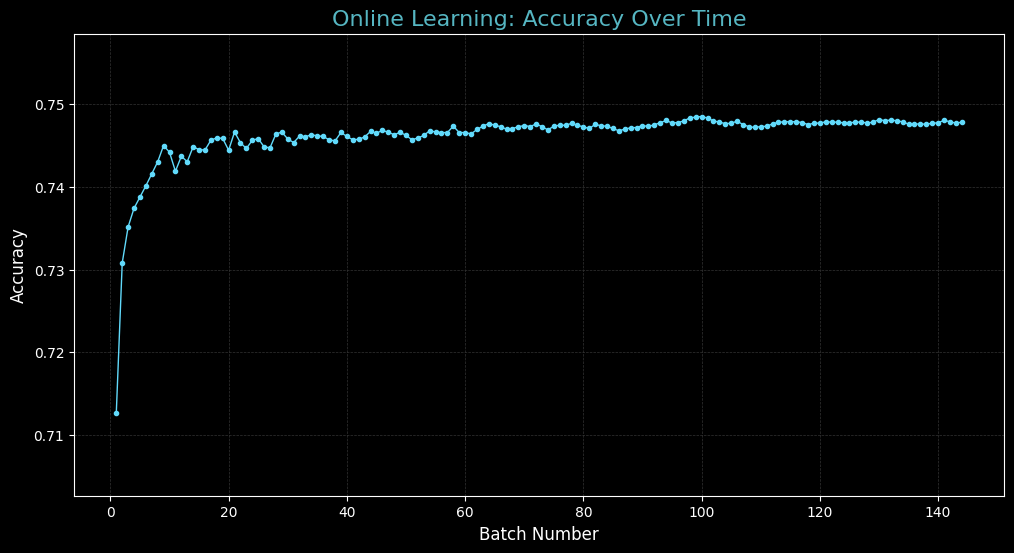

In [5]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')
plt.figure(figsize=(12, 6))

plt.plot(range(1, len(accuracy_over_time) + 1), accuracy_over_time, marker='o', markersize=3, color='#61dafb', linewidth=1)

plt.title('Online Learning: Accuracy Over Time', color='#56b6c2', fontsize=16)
plt.xlabel('Batch Number', color='white', fontsize=12)
plt.ylabel('Accuracy', color='white', fontsize=12)

plt.grid(color='#333333', linestyle='--', linewidth=0.5)
plt.ylim(min(accuracy_over_time) - 0.01, max(accuracy_over_time) + 0.01)

plt.show()
